In [1]:
import chainer
from chainer import functions as F
from chainer import links as L
from chainer import optimizers as O
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MLPGaussianRegressor(chainer.ChainList):

    def __init__(self, sizes):
        layers = [L.Linear(n_in, n_out)
                  for n_in, n_out in zip(sizes, sizes[1:])]
        super().__init__(*layers)

    def __call__(self, x):
        h = x
        for l in self[:-1]:
            h = F.relu(l(h))
        h = self[-1](h)
        mean, raw_var = F.split_axis(h, (1,), axis=1)
        var = F.softplus(raw_var) + 1e-6
        return mean, var

    def nll(self, x, t):
        mean, var = self(x)
        return F.gaussian_nll(t, mean, F.log(var))

In [3]:
def ensemble_mean_var(ensemble, x):
    en_mean = 0
    en_var = 0
    for model in ensemble:
        mean, var = model(x)
        en_mean += mean
        en_var += var + mean ** 2
    en_mean /= len(ensemble)
    en_var /= len(ensemble)
    en_var -= en_mean ** 2
    return en_mean, en_var

In [4]:
K = 10  # ensemble size
max_iter = 5000
batchsize = 32
eps = 1e-2
alpha = 0.5
gpu = 0

ensemble = [MLPGaussianRegressor((1, 20, 20, 2)) for _ in range(K)]
optimizers = [O.Adam() for _ in range(K)]

if gpu >= 0:
    chainer.cuda.get_device(gpu).use()
    for model in ensemble:
        model.to_gpu(gpu)

for model, opt in zip(ensemble, optimizers):
    opt.setup(model)

xp = ensemble[0].xp

xs = np.expand_dims(np.linspace(-5, 5, num=100, dtype=np.float32), -1)
ts = np.cos(xs)

for it in range(max_iter):
    for model, opt in zip(ensemble, optimizers):
        indices = np.random.choice(np.arange(len(xs)), size=batchsize)
        x = chainer.Variable(xp.asarray(xs[indices]))
        t = chainer.Variable(xp.asarray(ts[indices]))
        # Minimize NLL for real inputs
        nll = model.nll(x, t)
        model.cleargrads()
        (alpha * nll).backward()
        # Minimize NLL for adversarial inputs
        x_prime = x + eps * xp.sign(x.grad)
        nll_at = model.nll(x_prime, t)
        ((1 - alpha) * nll_at).backward()
        opt.update()
        if it % 100 == 0:
            print('it', it, 'nll', nll.data)

/Users/user/chainer/chainer/cuda.py:90: UserWarning: cuDNN is not enabled.
Please reinstall chainer after you install cudnn
(see https://github.com/pfnet/chainer#installation).
  'cuDNN is not enabled.\n'


it 0 nll 87.28772735595703
it 0 nll 130.7630615234375
it 0 nll 55.84734344482422
it 0 nll 45.24873352050781
it 0 nll 1152.3551025390625
it 0 nll 794.1105346679688
it 0 nll 130.91305541992188
it 0 nll 1256.25146484375
it 0 nll 58.83638000488281
it 0 nll 821.405029296875
it 100 nll 26.95749855041504
it 100 nll 28.77887535095215
it 100 nll 22.648683547973633
it 100 nll 28.20245361328125
it 100 nll 34.994842529296875
it 100 nll 27.884803771972656
it 100 nll 25.365833282470703
it 100 nll 23.264389038085938
it 100 nll 26.683109283447266
it 100 nll 20.894969940185547
it 200 nll 23.305723190307617
it 200 nll 27.2061767578125
it 200 nll 27.74390411376953
it 200 nll 23.88311767578125
it 200 nll 35.748191833496094
it 200 nll 26.324031829833984
it 200 nll 24.73826026916504
it 200 nll 26.41449546813965
it 200 nll 25.345582962036133
it 200 nll 26.621368408203125
it 300 nll 27.086162567138672
it 300 nll 22.023906707763672
it 300 nll 26.638837814331055
it 300 nll 19.099895477294922
it 300 nll 34.34267

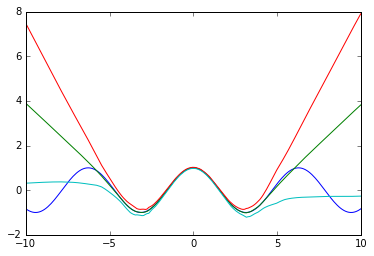

In [5]:
test_xs = xp.expand_dims(xp.linspace(-10, 10, num=200, dtype=np.float32), -1)
mean, var = ensemble_mean_var(ensemble, test_xs)
# mean, var = ensemble[9](test_xs)
mean = chainer.cuda.to_cpu(mean.data)
var = chainer.cuda.to_cpu(var.data)
std = np.sqrt(var)
upper = mean + 3 * std
lower = mean - 3 * std
test_xs_cpu = chainer.cuda.to_cpu(test_xs)
plt.plot(test_xs_cpu, np.cos(test_xs_cpu))
plt.plot(test_xs_cpu, mean)
plt.plot(test_xs_cpu, upper)
plt.plot(test_xs_cpu, lower)